<a href="https://colab.research.google.com/github/Vinay1727/Fake-Viral-News-Detection/blob/main/Drug_Discovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-tuner --upgrade
!pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 72.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight


In [ ]:
# Load dataset
df = pd.read_csv("tox21.csv")
df = df[['smiles', 'NR-AR']].dropna()

In [ ]:
# Convert SMILES to Morgan Fingerprint
def featurize_smiles(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros((nBits,))
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)

X_fp = np.array([featurize_smiles(smi) for smi in df['smiles']])

[13:02:00] WARNING: not removing hydrogen atom without neighbors


In [ ]:
# Add descriptors for better generalization
df['MolWt'] = df['smiles'].apply(lambda x: Descriptors.MolWt(Chem.MolFromSmiles(x)))
df['LogP'] = df['smiles'].apply(lambda x: Descriptors.MolLogP(Chem.MolFromSmiles(x)))
desc_features = df[['MolWt', 'LogP']].to_numpy()


[13:02:29] WARNING: not removing hydrogen atom without neighbors
[13:02:30] WARNING: not removing hydrogen atom without neighbors


In [ ]:
# Final combined feature set
X = np.hstack([X_fp, desc_features])
y = df['NR-AR'].values

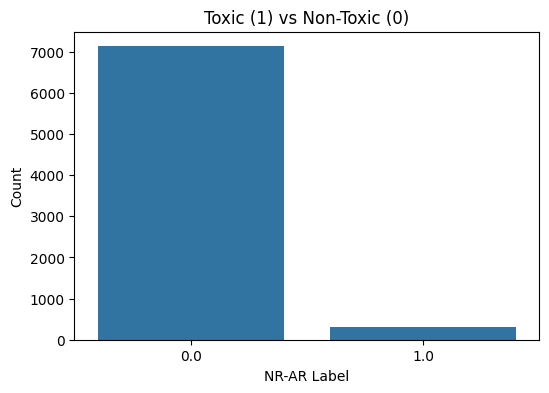

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title('Toxic (1) vs Non-Toxic (0)')
plt.xlabel('NR-AR Label')
plt.ylabel('Count')
plt.show()

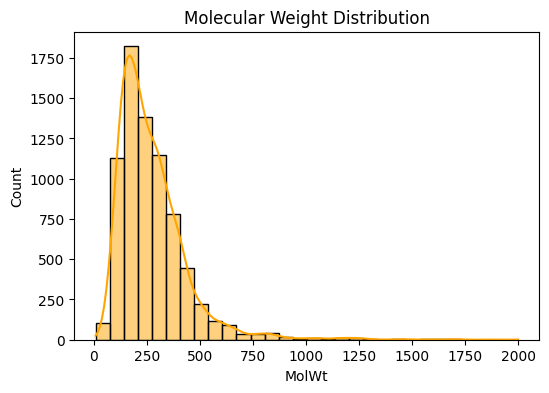

In [ ]:
# 2. Molecular Weight Distribution
plt.figure(figsize=(6,4))
sns.histplot(df['MolWt'], bins=30, kde=True, color='orange')
plt.title('Molecular Weight Distribution')
plt.xlabel('MolWt')
plt.show()

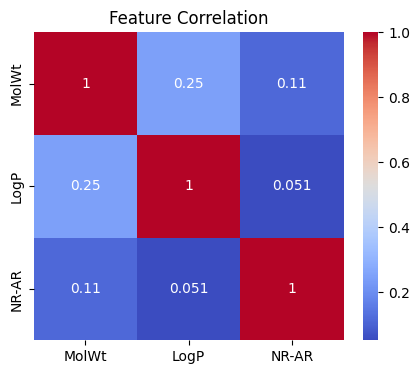

In [ ]:
# 3. Correlation Heatmap
plt.figure(figsize=(5,4))
sns.heatmap(df[['MolWt', 'LogP', 'NR-AR']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()

In [ ]:
import keras_tuner as kt
from tensorflow import keras
from rdkit.Chem import Descriptors

df['TPSA'] = df['smiles'].apply(lambda x: Descriptors.TPSA(Chem.MolFromSmiles(x)))
df['NumRotatableBonds'] = df['smiles'].apply(lambda x: Descriptors.NumRotatableBonds(Chem.MolFromSmiles(x)))
desc_features = df[['MolWt', 'LogP', 'TPSA', 'NumRotatableBonds']].to_numpy()
X = np.hstack([X_fp, desc_features])

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


[13:32:09] WARNING: not removing hydrogen atom without neighbors
[13:32:10] WARNING: not removing hydrogen atom without neighbors


In [ ]:
# Compute class weights
cw = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), cw))

In [ ]:
# Define tuner model
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(X.shape[1],)))

    model.add(keras.layers.Dense(units=hp.Int('units1', 128, 1024, step=128), activation='relu'))
    model.add(keras.layers.Dense(units=hp.Int('units2', 64, 512, step=64), activation='relu'))

    if hp.Boolean("use_third_layer"):
        model.add(keras.layers.Dense(units=hp.Int('units3', 32, 256, step=32), activation='relu'))

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )

    return model

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9)

In [ ]:
# Search for best model
tuner = kt.RandomSearch(
    build_model,
    objective='val_auc',
    max_trials=20,
    executions_per_trial=1,
    directory='my_dir',
    project_name='toxicity_tuning'
)

tuner.search(X_train, y_train,
             validation_split=0.2,
             epochs=2,
             batch_size=32,
             class_weight=class_weight_dict,
             verbose=1)

Trial 20 Complete [00h 00m 08s]
val_auc: 0.7856627702713013

Best val_auc So Far: 0.789183497428894
Total elapsed time: 00h 29m 39s


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

best_model = tuner.get_best_models(num_models=1)[0]


In [ ]:
# Predict with best model
y_probs = best_model.predict(X_test)
y_pred = (y_probs > 0.35).astype(int)  # Lower threshold to improve recall

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_probs))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.7405913978494624
AUC: 0.6761242817717052

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.75      0.85      1426
         1.0       0.08      0.50      0.14        62

    accuracy                           0.74      1488
   macro avg       0.53      0.63      0.49      1488
weighted avg       0.93      0.74      0.82      1488

